### Define Event and Schedule classes

In [35]:
import heapq
import numpy as np

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

### Define Queue and GroceryStore classes

In [36]:
import numpy as np
class Queue:
    '''
    Store the properties of a single queue. Each queue has a service time distribution and
    a queue type (either regular or manager). 
    '''
    def __init__(self, service_distribution, queue_type = "regular", manager_queue = None):
        self.service_distribution = service_distribution
        self.queue_type = queue_type
        if self.queue_type == "regular":
            # If queue type is regular, manager queue is defined
            self.manager_queue = manager_queue
        # We start with an empty queue, the server not busy, and the total 0 people joined
        self.people_in_queue = 0
        self.people_being_served = 0
        self.total_people_joined = 0

        # Record arrival times 
        self.arrival_times = []
        # Record queue departure times
        self.departure_times = []
        # Record service finish times
        self.finish_times = []

    def add_customer(self, schedule):
        '''
        It adds a new customer to the queue. 
        '''
        # Add the customer to the queue
        self.people_in_queue += 1
        # Add the customer to the total people joined
        self.total_people_joined += 1
        # Add customer arrival time to queue arrival times list
        self.arrival_times.append(schedule.now)
        if self.people_being_served < 1: # If cashier is not busy
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        '''
        This method starts serving a customer and schedules the end of service. 
        '''
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        # Mark the cashier busy
        self.people_being_served += 1
        # Add queue departure time to the queue departure times
        self.departure_times.append(schedule.now)
        # Schedule when the server will be done with the customer
        service_time = self.service_distribution.rvs()
        while service_time < 0: # Resample if the service time sample is less than 0
            service_time = self.service_distribution.rvs()
        schedule.add_event_after(
            service_time,
            self.finish_serving_customer)
            
    def finish_serving_customer(self, schedule):
        '''
        This finishes the service and starts serving the next customer in the queue. 
        If the queue is regular, see if it is in the 5% that joins the manager queue. 
        '''
        # Remove the customer from the server
        self.people_being_served -= 1
        self.finish_times.append(schedule.now)
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)
        # Add customer to the manager queue in the rare case of 5% probability 
        if self.queue_type == "regular" and np.random.rand() < 0.05:
            schedule.add_event_after(0, self.manager_queue.add_customer)

class GroceryStore:
    '''
    Implement the grocery store system with one or more queues. It stores the attributes of 
    of the grocery store, including number of queues, arrival distribution, cashier and 
    manager service distribution. 
    '''
    def __init__(self, arrival_distribution, service_distribution, manager_service_distribution, num_of_queues, run_until):
        self.arrival_distribution = arrival_distribution
        self.num_of_queues = num_of_queues
        self.run_until = run_until
        self.manager_queue = Queue(manager_service_distribution, queue_type = "manager")
        self.queue_list = []
        for i in range(num_of_queues):
            self.queue_list.append(Queue(service_distribution, manager_queue=self.manager_queue))

    def add_customer(self, schedule):
        # Define the shortest queue 
        queue = self.queue_list[0]
        for i in range(self.num_of_queues): 
            if self.queue_list[i].people_in_queue < queue.people_in_queue:
                queue = self.queue_list[i]
        # Add the customer to the shortest queue
        queue.add_customer(schedule)
        # Schedule when to add another customer
        if schedule.now < self.run_until:
            # Schedule new customer arrival until the closing time
            schedule.add_event_after(
                self.arrival_distribution.rvs(),
                self.add_customer)

    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        

def run_simulation(arrival_distribution, service_distribution, manager_service_distribution, run_until, num_of_queues):
    '''
    This function runs a simulation of the system with given inputs.
    Input:
        - arrival_distribution: customer arrival distribution (exponential)
        - service_distribution: cashier service time distribution (Gaussian)
        - manager_service_distribution: manager service distribution (Gaussian)
        - run_until: [int] the time duration to run the simulation in minutes
        - num_of_queues: [int] the number of cashiers in the grocery store
    Output:
        - grocery_store: the grocery store object of GroceryStore class
        - plot_data: dictionary containing waiting times, response times, people in queue for all queues 
        and total people in system
    '''
    plot_data = {"Waiting times": [], "Response times": [], "People in queue": [], "Total people in system": [], 
        "Waiting times manager queue": [], "Response times manager queue": [], "People in manager queue": [], "Total people in extended system": []}
    schedule = Schedule()
    grocery_store = GroceryStore(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_service_distribution=manager_service_distribution, num_of_queues=num_of_queues, run_until=run_until)
    grocery_store.run(schedule)
    while len(schedule.priority_queue) > 0:
        # Run the next event into the scheduler until the priority queue is empty
        schedule.run_next_event()
        # Put together total people in system
        total_customers = 0
        for i in range(num_of_queues):
            total_customers += grocery_store.queue_list[i].people_in_queue
            total_customers += grocery_store.queue_list[i].people_being_served
        plot_data["Total people in system"].append((total_customers, schedule.now))
        # Put together queue length measures for all queues
        for i in range(num_of_queues):
            plot_data["People in queue"].append((grocery_store.queue_list[i].people_in_queue, schedule.now))
        # Put together total people in extended service system
        plot_data["Total people in extended system"].append((grocery_store.manager_queue.people_in_queue + grocery_store.manager_queue.people_being_served, schedule.now))
        # Put together queue length measure for manager queue
        plot_data["People in manager queue"].append((grocery_store.manager_queue.people_in_queue, schedule.now))   
    # Record waiting times 
    for i in range(num_of_queues):
        plot_data["Waiting times"] += (np.array(grocery_store.queue_list[i].departure_times) - np.array(grocery_store.queue_list[i].arrival_times)).tolist()
    # Record response times 
    for i in range(num_of_queues):
        plot_data["Response times"] += (np.array(grocery_store.queue_list[i].finish_times) - np.array(grocery_store.queue_list[i].arrival_times)).tolist()
    # Record manager queue waiting times 
    plot_data["Waiting times manager queue"] += (np.array(grocery_store.manager_queue.departure_times) - np.array(grocery_store.manager_queue.arrival_times)).tolist()
    # Record manager queue response times 
    plot_data["Response times manager queue"] += (np.array(grocery_store.manager_queue.finish_times) - np.array(grocery_store.manager_queue.arrival_times)).tolist()
    return grocery_store, plot_data

### Tests

Run small tests to check if the model simulation is running accurately. 

Test 1: one server/queue

Test 2: three servers/queues

In [37]:
# Run a short test with an M/G/1 * c queue
import scipy.stats as sts
import matplotlib.pyplot as plt
from tqdm import tqdm

def test_simulation(num_of_queues):
    '''
    This function runs a test simulation for the given number of queues to see if the model 
    simulation works properly.
    '''
    arrival_distribution = sts.expon(scale=1/1)
    service_distribution = sts.norm(loc=3, scale=1)
    manager_service_distribution = sts.norm(loc=5, scale=2)
    np.random.seed(123)
    # mins since 9 AM (until 8pm)
    run_until = 660

    # Run simulation of the grocery store with given number of queues
    grocery_store, plot_data = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, 
        manager_service_distribution=manager_service_distribution, run_until=run_until, num_of_queues=num_of_queues)

    # Total number of people that joined each queue
    for i in range(len(grocery_store.queue_list)):
        print(f'The total number of people that have joined queue No. {i+1}: {grocery_store.queue_list[i].total_people_joined}')
    print(f'The total number of people that have joined manager queue: {grocery_store.manager_queue.total_people_joined}')

    data = plot_data["People in queue"]
    y = list(zip(*data))[0]
    x = list(zip(*data))[1]
    plt.title(f"M/G/1 * c test for c={num_of_queues}")
    plt.xlabel("Time [mins since 9 AM]")
    plt.ylabel("Average queue length")
    plt.plot(x, y)
    total_num_customers = 0
    for i in range(len(grocery_store.queue_list)):
        total_num_customers += grocery_store.queue_list[i].total_people_joined
    print(f"Store finished serving {total_num_customers} customers {x[-1]//60} hours {round(x[-1]%60,2)} mins after 9AM")

The total number of people that have joined queue No. 1: 677
The total number of people that have joined manager queue: 35
Store finished serving 677 customers 33.0 hours 34.82 mins after 9AM


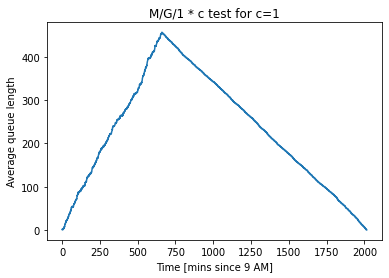

In [38]:
# Test 1: one server/queue
test_simulation(num_of_queues=1)

The total number of people that have joined queue No. 1: 222
The total number of people that have joined queue No. 2: 212
The total number of people that have joined queue No. 3: 193
The total number of people that have joined manager queue: 32
Store finished serving 627 customers 11.0 hours 10.27 mins after 9AM


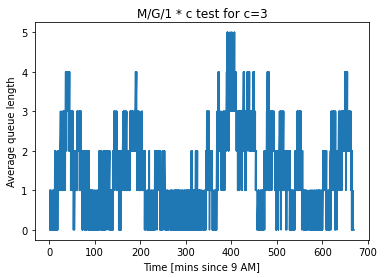

In [39]:
# Test 2: three servers/queues
test_simulation(num_of_queues=3)

### Experiment

Run an experiment for different number of servers/queues for M/G/1 *c system.

In [40]:
def confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), sts.sem(a)
    h = se * sts.t.ppf((1 + confidence) / 2., n-1)
    return [m-h, m+h]


def calculate_statistics(data):
    #mean
    p_tail = 0.025
    m = np.mean(data)
    n = len(data)
    df = n-1
    m_approx = round(m, 2)
    #starndard error
    sd = np.std(data)
    se = sd/(n-1) #Bessel's correction 
    se_approx = round(se, 2)
    confidence_int = confidence_interval(data)
    return[m_approx, se_approx, confidence_int]

In [41]:
def run_experiment(num_queues_list, measurement, num_trials=10, run_until=660):
    '''
    Run an experiment with different number of queues for an M/G/1 * c model.
    Input: 
        - num_queues_list: [list] a list that contains different number of queues to run the experiment with.
        - measurement: [str] a measurement variable
        - num_trials: [int] the number of trials to run a simulation for different number of queues 
        - run_until: [int] the time duration to run the simulation in minutes
    Output: 
        - results_mean: the mean value of the given measurement 
        - results_std_err: the standard error of the mean for each measurement
    '''
    # We record only the mean and standard error of the mean for each experiment/measurement
    results_mean = []
    results_std_err = []

    arrival_distribution = sts.expon(scale=1/1)
    service_distribution = sts.norm(loc=3, scale=1)
    manager_service_distribution = sts.norm(loc=5, scale=2)

    for num in tqdm(num_queues_list):
        results = []
        for trial in range(num_trials):
            grocery_store, plot_data = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, 
                manager_service_distribution=manager_service_distribution, run_until=run_until, num_of_queues=num)
            if measurement in ["Total people in system", "People in queue", "Total people in extended system", "People in manager queue"]:
                data = plot_data[measurement]
                results += list(zip(*data))[0]
            elif measurement == "Max queue length": 
                data = plot_data["People in queue"]
                results += [max(list(zip(*data))[0])]
            else:
                results += plot_data[measurement]
        #print(results)
        stats = calculate_statistics(results)
        m = stats[0]
        se = stats[1]
        confidence_mean = stats[2] # for the mean
        quantiles = np.quantile(results, [0.025, 0.975]) # 95% HDI for the samples
        results_mean.append(m)
        results_std_err.append(se)
        
        if (not "manager" in measurement) and (not "extended" in measurement):
        # Make a histogram
            plt.figure()
            plt.hist(results, bins = 14, edgecolor='white')  
            plt.axvline(x = m, color = 'red', label = 'mean')
            plt.axvline(x = confidence_mean[0], color = 'orange', label = '95% CI for the mean')
            plt.axvline(x = confidence_mean[1], color = 'orange')
            plt.axvline(x = quantiles[0], color = 'black', label = '95% HDI for samples')
            plt.axvline(x = quantiles[1], color = 'black')
            plt.xlabel(measurement)
            plt.ylabel('Frequency')
            plt.title(f'{measurement} over {num_trials} trial of simulation with {num} cashiers')
            plt.legend()
            plt.show()
            print(stats)

    # Convert lists to arrays so we can easily add, subtract, and multiply them
    results_mean = np.array(results_mean)
    results_std_err = np.array(results_std_err)
    
    return results_mean, results_std_err

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


  0%|          | 0/10 [00:00<?, ?it/s]

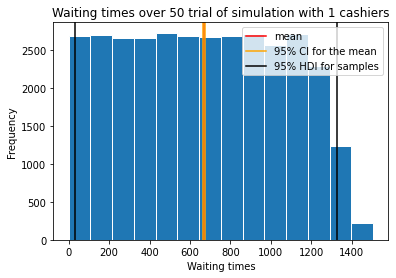

 10%|█         | 1/10 [00:02<00:21,  2.34s/it]

[668.11, 0.01, [663.926768315597, 672.2905561016248]]


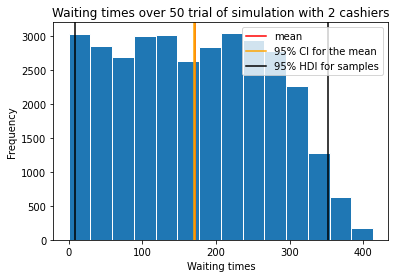

 20%|██        | 2/10 [00:04<00:19,  2.40s/it]

[171.09, 0.0, [169.9983597356265, 172.17210752671295]]


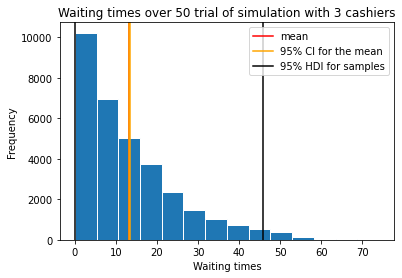

 30%|███       | 3/10 [00:07<00:16,  2.43s/it]

[13.29, 0.0, [13.159569935354906, 13.420310935951651]]


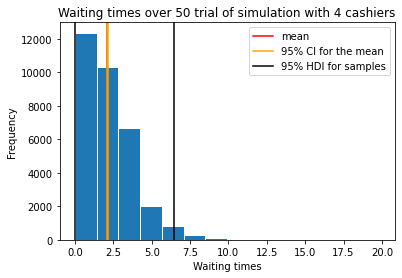

 40%|████      | 4/10 [00:09<00:14,  2.43s/it]

[2.11, 0.0, [2.0948845725905585, 2.1347367375795585]]


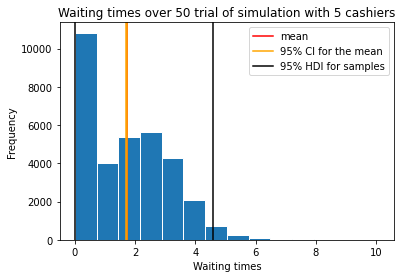

 50%|█████     | 5/10 [00:12<00:12,  2.50s/it]

[1.72, 0.0, [1.7038514078026121, 1.734737572555905]]


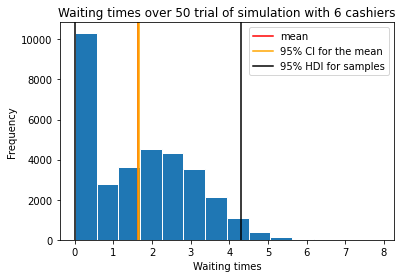

 60%|██████    | 6/10 [00:14<00:10,  2.54s/it]

[1.64, 0.0, [1.625865549255641, 1.6553944167700756]]


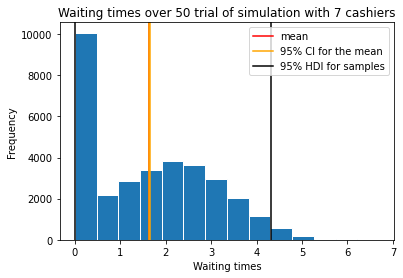

 70%|███████   | 7/10 [00:17<00:07,  2.60s/it]

[1.64, 0.0, [1.6256020626997294, 1.6552359781020451]]


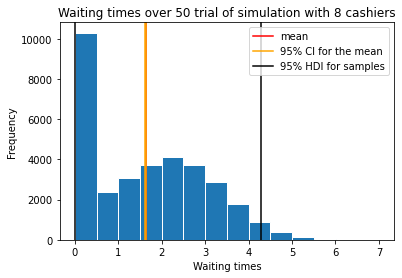

 80%|████████  | 8/10 [00:20<00:05,  2.61s/it]

[1.63, 0.0, [1.6147449529035565, 1.6439480054522884]]


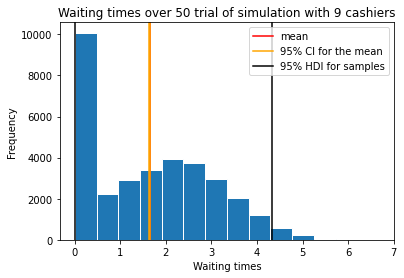

 90%|█████████ | 9/10 [00:22<00:02,  2.64s/it]

[1.64, 0.0, [1.628603982680644, 1.6579525793652152]]


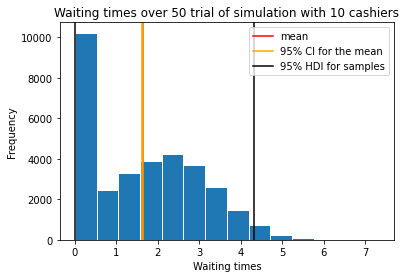

100%|██████████| 10/10 [00:25<00:00,  2.58s/it]


[1.64, 0.0, [1.622087260736826, 1.6516289146834473]]


  0%|          | 0/10 [00:00<?, ?it/s]

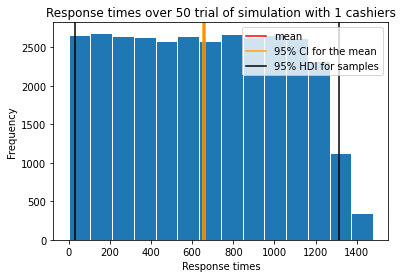

 10%|█         | 1/10 [00:02<00:20,  2.33s/it]

[658.61, 0.01, [654.4576413054754, 662.7722474253417]]


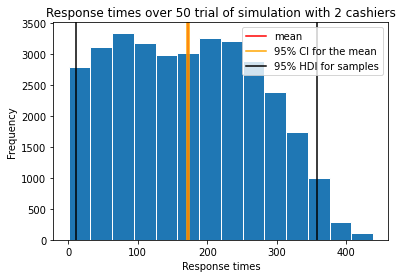

 20%|██        | 2/10 [00:04<00:19,  2.38s/it]

[172.36, 0.0, [171.27237173307472, 173.439989788357]]


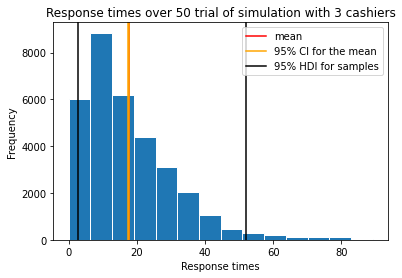

 30%|███       | 3/10 [00:07<00:16,  2.36s/it]

[17.71, 0.0, [17.571020959464413, 17.85626028190255]]


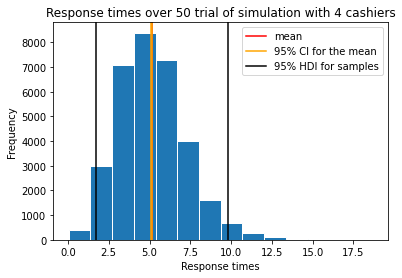

 40%|████      | 4/10 [00:09<00:14,  2.37s/it]

[5.14, 0.0, [5.118435271091542, 5.163013593925163]]


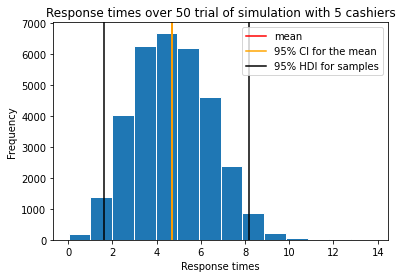

 50%|█████     | 5/10 [00:11<00:11,  2.40s/it]

[4.7, 0.0, [4.679421013415613, 4.716977378583344]]


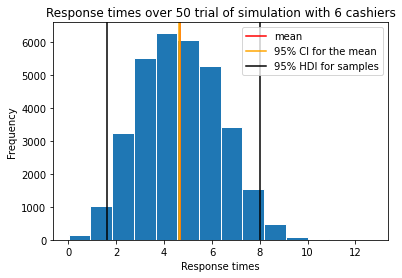

 60%|██████    | 6/10 [00:14<00:09,  2.49s/it]

[4.66, 0.0, [4.640924077538715, 4.677270507667632]]


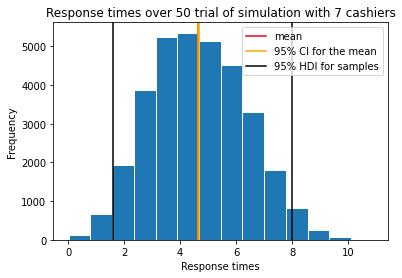

 70%|███████   | 7/10 [00:17<00:07,  2.52s/it]

[4.65, 0.0, [4.630209806094044, 4.6667556794157665]]


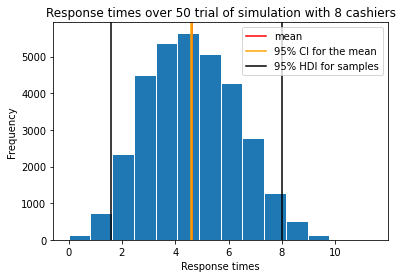

 80%|████████  | 8/10 [00:19<00:05,  2.56s/it]

[4.63, 0.0, [4.608424378271346, 4.645158338075582]]


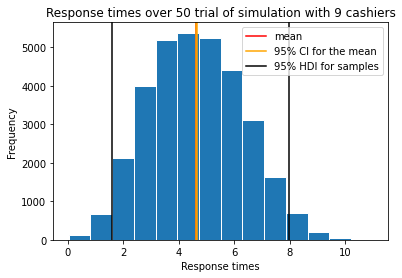

 90%|█████████ | 9/10 [00:22<00:02,  2.63s/it]

[4.63, 0.0, [4.608190968916966, 4.6446426824867535]]


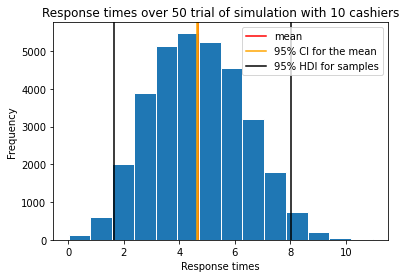

100%|██████████| 10/10 [00:25<00:00,  2.54s/it]


[4.67, 0.0, [4.648646662536391, 4.684983171416585]]


  0%|          | 0/10 [00:00<?, ?it/s]

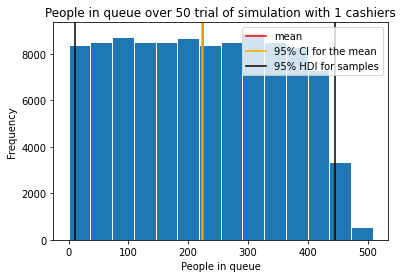

 10%|█         | 1/10 [00:02<00:22,  2.46s/it]

[224.56, 0.0, [223.77616730581914, 225.34837220356204]]


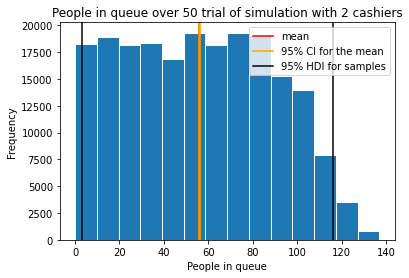

 20%|██        | 2/10 [00:05<00:21,  2.66s/it]

[55.98, 0.0, [55.83342535409489, 56.11790182420862]]


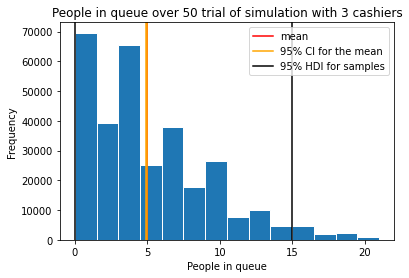

 30%|███       | 3/10 [00:08<00:20,  2.93s/it]

[4.95, 0.0, [4.938901782928551, 4.967544727868781]]


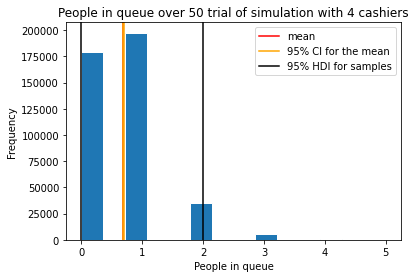

 40%|████      | 4/10 [00:12<00:19,  3.19s/it]

[0.69, 0.0, [0.6900094851448287, 0.6943014283787622]]


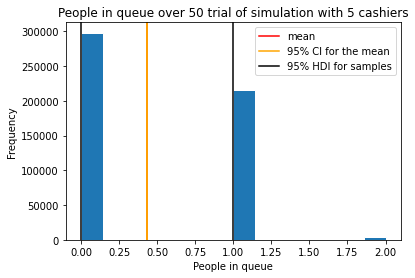

 50%|█████     | 5/10 [00:16<00:18,  3.62s/it]

[0.43, 0.0, [0.43218619901048816, 0.434982126990901]]


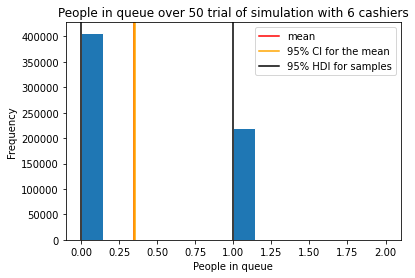

 60%|██████    | 6/10 [00:20<00:15,  3.91s/it]

[0.35, 0.0, [0.3502421883294598, 0.3526144261407799]]


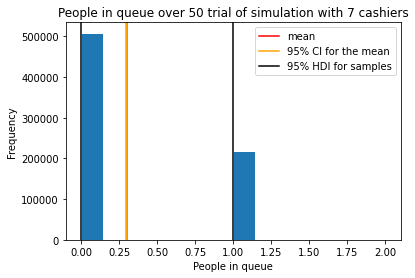

 70%|███████   | 7/10 [00:25<00:12,  4.16s/it]

[0.3, 0.0, [0.29860653029198164, 0.30071581350082793]]


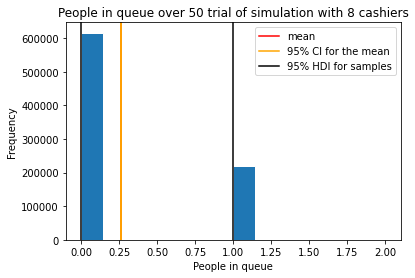

 80%|████████  | 8/10 [00:30<00:08,  4.47s/it]

[0.26, 0.0, [0.26055310405300486, 0.26243912082164406]]


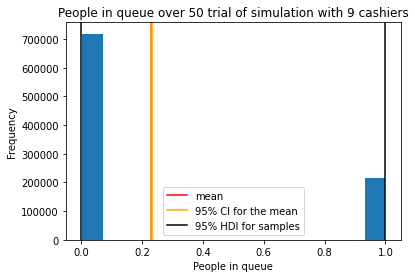

 90%|█████████ | 9/10 [00:36<00:04,  4.99s/it]

[0.23, 0.0, [0.2312157549692898, 0.23292209247222645]]


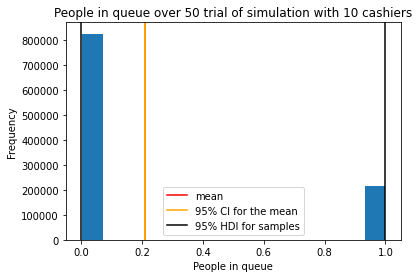

100%|██████████| 10/10 [00:43<00:00,  4.33s/it]


[0.21, 0.0, [0.20943358087249203, 0.2109923482282185]]


  0%|          | 0/10 [00:00<?, ?it/s]

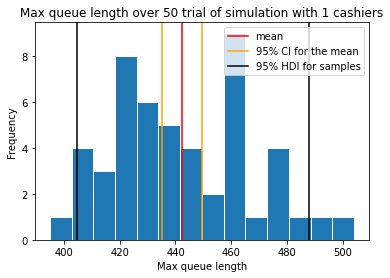

 10%|█         | 1/10 [00:02<00:20,  2.24s/it]

[442.22, 0.51, [435.0589734867785, 449.38102651322157]]


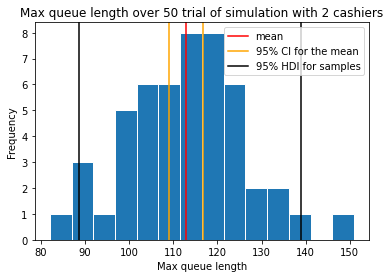

 20%|██        | 2/10 [00:04<00:18,  2.30s/it]

[112.84, 0.28, [108.94736893794266, 116.73263106205735]]


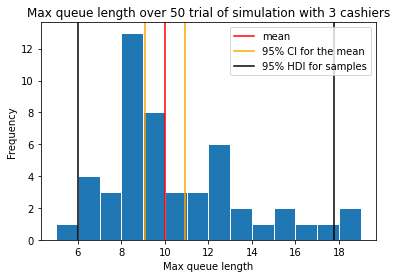

 30%|███       | 3/10 [00:07<00:16,  2.37s/it]

[10.02, 0.07, [9.096880130658073, 10.943119869341926]]


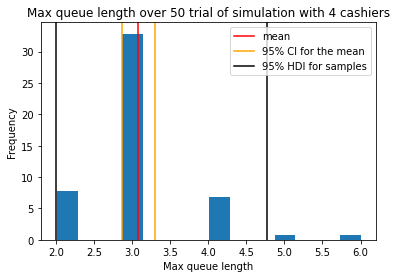

 40%|████      | 4/10 [00:09<00:14,  2.48s/it]

[3.08, 0.02, [2.8663985135278325, 3.2936014864721677]]


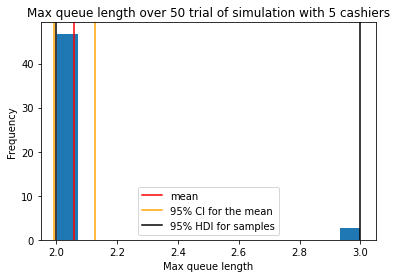

 50%|█████     | 5/10 [00:12<00:12,  2.57s/it]

[2.06, 0.0, [1.9918217606172448, 2.128178239382755]]


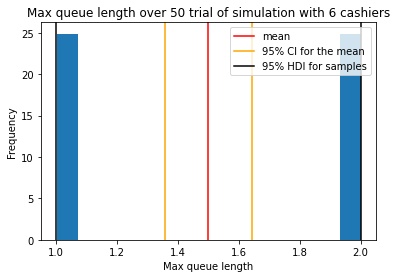

 60%|██████    | 6/10 [00:15<00:10,  2.68s/it]

[1.5, 0.01, [1.3564589118221995, 1.6435410881778005]]


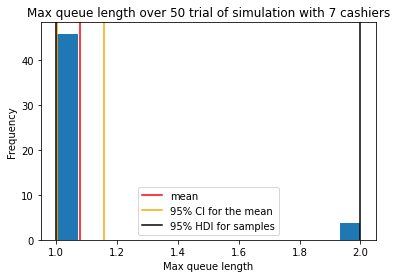

 70%|███████   | 7/10 [00:18<00:08,  2.97s/it]

[1.08, 0.01, [1.0021165579073021, 1.157883442092698]]


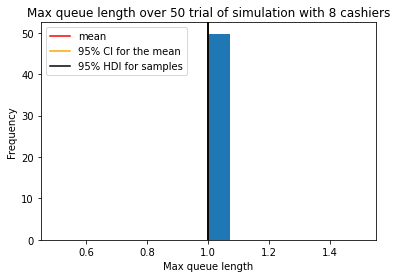

 80%|████████  | 8/10 [00:21<00:06,  3.01s/it]

[1.0, 0.0, [1.0, 1.0]]


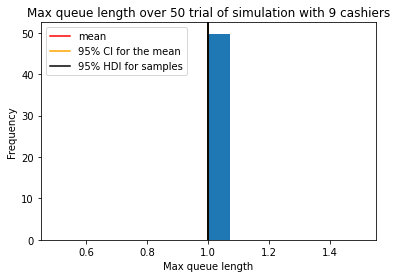

 90%|█████████ | 9/10 [00:25<00:03,  3.07s/it]

[1.0, 0.0, [1.0, 1.0]]


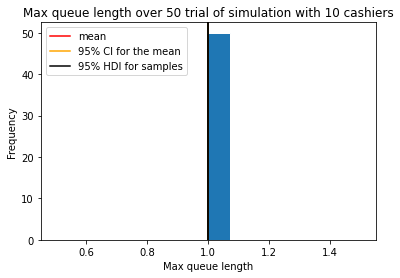

100%|██████████| 10/10 [00:28<00:00,  2.85s/it]


[1.0, 0.0, [1.0, 1.0]]


  0%|          | 0/10 [00:00<?, ?it/s]

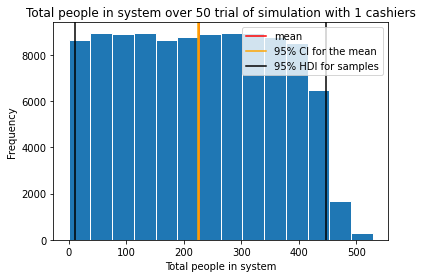

 10%|█         | 1/10 [00:02<00:22,  2.45s/it]

[226.14, 0.0, [225.34373968234152, 226.92951861656147]]


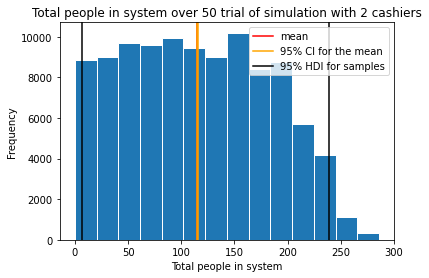

 20%|██        | 2/10 [00:04<00:19,  2.45s/it]

[115.21, 0.0, [114.79865774131558, 115.61476677451684]]


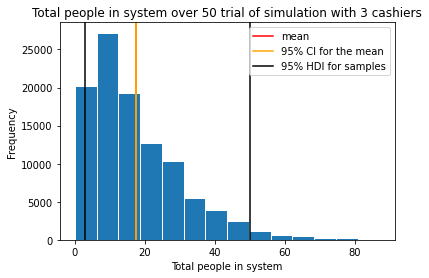

 30%|███       | 3/10 [00:07<00:17,  2.49s/it]

[17.45, 0.0, [17.36882090206146, 17.528078992362186]]


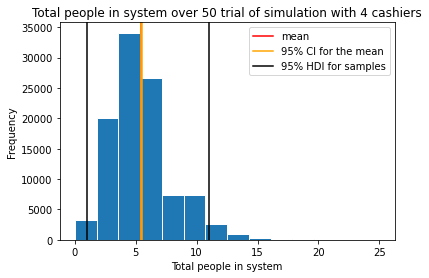

 40%|████      | 4/10 [00:10<00:15,  2.56s/it]

[5.46, 0.0, [5.439766591064593, 5.470841901566372]]


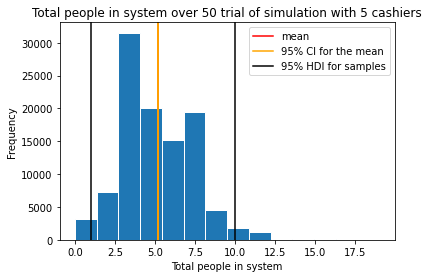

 50%|█████     | 5/10 [00:13<00:13,  2.76s/it]

[5.18, 0.0, [5.164327788287768, 5.191297778565065]]


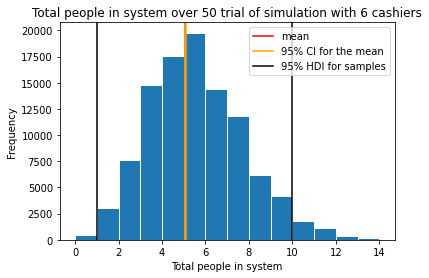

 60%|██████    | 6/10 [00:15<00:11,  2.77s/it]

[5.08, 0.0, [5.066035820659384, 5.092942109281233]]


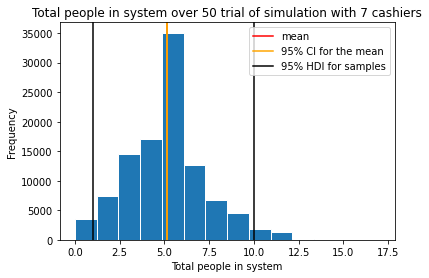

 70%|███████   | 7/10 [00:18<00:08,  2.84s/it]

[5.14, 0.0, [5.1236077513194695, 5.150297163210445]]


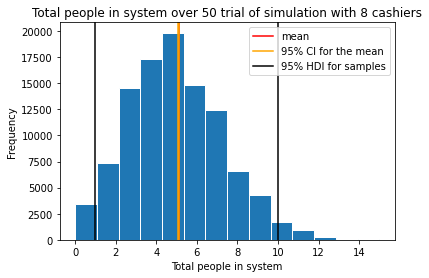

 80%|████████  | 8/10 [00:21<00:05,  2.85s/it]

[5.1, 0.0, [5.090553842707612, 5.117011496943011]]


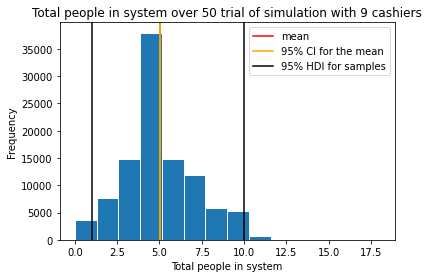

 90%|█████████ | 9/10 [00:24<00:02,  2.85s/it]

[5.02, 0.0, [5.0078410518779455, 5.034176980861106]]


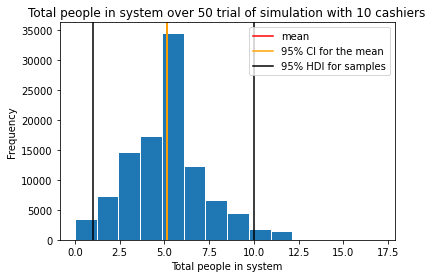

100%|██████████| 10/10 [00:27<00:00,  2.77s/it]

[5.14, 0.0, [5.122748742632503, 5.1497015275756155]]
M/G/1 * c experiment complete


In [42]:
# Run the M/G/1 queue experiment
num_queues_list = [i for i in range(1, 11)]
num_trials = 50
run_until = 660 # until 8 PM
print(num_queues_list)

np.random.seed(123)
avg_waiting_times_mean, avg_waiting_times_std_err = run_experiment(num_queues_list, measurement="Waiting times", num_trials=num_trials, run_until=run_until)
avg_response_times_mean, avg_response_times_std_err = run_experiment(num_queues_list, measurement="Response times", num_trials=num_trials, run_until=run_until)
avg_queue_length_mean, avg_queue_length_std_err = run_experiment(num_queues_list, measurement="People in queue", num_trials=num_trials, run_until=run_until)
max_queue_length_mean, max_queue_length_std_err = run_experiment(num_queues_list, measurement="Max queue length", num_trials=num_trials, run_until=run_until)
total_people_in_system_mean, total_people_in_system_std_err = run_experiment(num_queues_list, measurement="Total people in system", num_trials=num_trials, run_until=run_until)
print('M/G/1 * c experiment complete')

In [43]:
# Run experiment for extended service queue metrics
avg_manager_waiting_times_mean, avg_manager_waiting_times_std_err = run_experiment(num_queues_list, measurement="Waiting times manager queue", num_trials=num_trials, run_until=run_until)
avg_manager_response_times_mean, avg_manager_response_times_std_err = run_experiment(num_queues_list, measurement="Response times manager queue", num_trials=num_trials, run_until=run_until)
avg_manager_queue_length_mean, avg_manager_queue_length_std_err = run_experiment(num_queues_list, measurement="People in manager queue", num_trials=num_trials, run_until=run_until)
total_people_in_extended_system_mean, total_people_in_extended_system_std_err = run_experiment(num_queues_list, measurement="Total people in extended system", num_trials=num_trials, run_until=run_until)

100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


In [44]:
# Average waiting times for number of queues ranging from 1 to 10
print("Average waiting times: ", avg_waiting_times_mean)
# Average response times for number of queues ranging from 1 to 10
print("Average response times: ", avg_response_times_mean)
# Average queue lengths for number of queues ranging from 1 to 10
print("Average queue length: ", avg_queue_length_mean)
# Average maximum queue lengths for number of queues ranging from 1 to 10
print("Average maximum queue length: ", max_queue_length_mean)
# Average number of customers in the system for number of queues ranging from 1 to 10
print("Total people in system: ", total_people_in_system_mean)

Average waiting times:  [668.11 171.09  13.29   2.11   1.72   1.64   1.64   1.63   1.64   1.64]
Average response times:  [658.61 172.36  17.71   5.14   4.7    4.66   4.65   4.63   4.63   4.67]
Average queue length:  [2.2456e+02 5.5980e+01 4.9500e+00 6.9000e-01 4.3000e-01 3.5000e-01
 3.0000e-01 2.6000e-01 2.3000e-01 2.1000e-01]
Average maximum queue length:  [442.22 112.84  10.02   3.08   2.06   1.5    1.08   1.     1.     1.  ]
Total people in system:  [226.14 115.21  17.45   5.46   5.18   5.08   5.14   5.1    5.02   5.14]


In [45]:
# Average waiting times for number of queues ranging from 1 to 10
print("Average waiting times /manager queue/: ", avg_manager_waiting_times_mean)
# Average response times for number of queues ranging from 1 to 10
print("Average response times /manager queue/: ", avg_manager_response_times_mean)
# Average queue lengths for number of queues ranging from 1 to 10
print("Average queue length /manager queue/: ", avg_manager_queue_length_mean)
# Average number of customers in the system for number of queues ranging from 1 to 10
print("Total people in extended system: ", total_people_in_extended_system_mean)

Average waiting times /manager queue/:  [0.14 0.54 0.74 0.76 0.91 0.99 0.82 0.87 0.94 0.88]
Average response times /manager queue/:  [5.18 5.54 5.88 6.06 5.97 5.95 5.95 5.98 5.9  6.07]
Average queue length /manager queue/:  [0.02 0.03 0.05 0.06 0.07 0.07 0.06 0.06 0.07 0.06]
Total people in extended system:  [0.1  0.19 0.29 0.3  0.32 0.31 0.33 0.32 0.33 0.34]


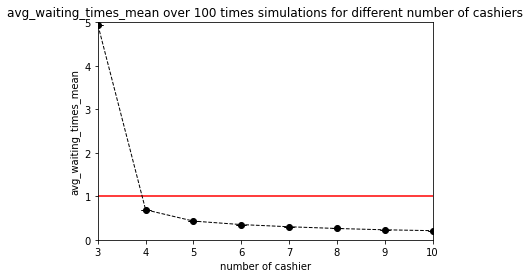

224.560000
55.980000
4.950000
0.690000
0.430000
0.350000
0.300000
0.260000
0.230000
0.210000


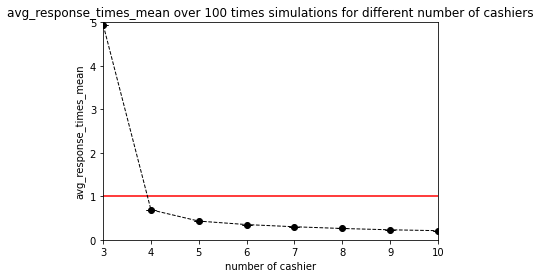

224.560000
55.980000
4.950000
0.690000
0.430000
0.350000
0.300000
0.260000
0.230000
0.210000


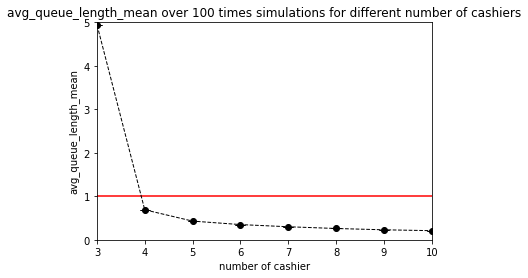

224.560000
55.980000
4.950000
0.690000
0.430000
0.350000
0.300000
0.260000
0.230000
0.210000


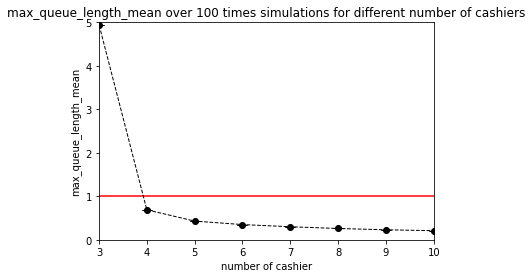

224.560000
55.980000
4.950000
0.690000
0.430000
0.350000
0.300000
0.260000
0.230000
0.210000


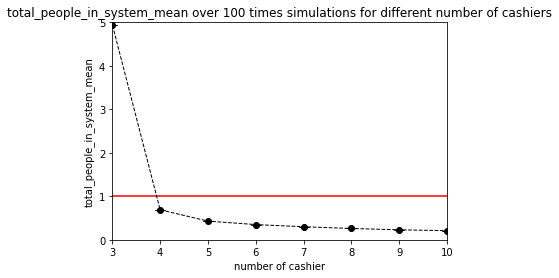

224.560000
55.980000
4.950000
0.690000
0.430000
0.350000
0.300000
0.260000
0.230000
0.210000
[2.2456e+02 5.5980e+01 4.9500e+00 6.9000e-01 4.3000e-01 3.5000e-01
 3.0000e-01 2.6000e-01 2.3000e-01 2.1000e-01]


In [46]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

data_list = [avg_waiting_times_mean, avg_response_times_mean, avg_queue_length_mean, max_queue_length_mean, total_people_in_system_mean]
err_list = [avg_waiting_times_std_err, avg_response_times_std_err, avg_queue_length_std_err, max_queue_length_std_err, total_people_in_system_std_err]

for index in range(5):
    data = data_list[index]
    err = err_list[index]
    
    plt.errorbar(
        range(1, 11), avg_queue_length_mean, avg_queue_length_std_err,
        color='black', marker='o', capsize=5, linestyle='--', linewidth=1)
    plt.axhline(y = 1, color = 'r', linestyle = '-', label = 'queue length = 5')
    plt.xlabel('number of cashier')
    plt.ylabel(namestr(data,globals())[0])
    plt.title(namestr(data,globals())[0]+' over 100 times simulations for different number of cashiers')
    plt.axis([3, 10, 0,5])
    plt.show()

    for index in range(len(avg_queue_length_mean)):
        item = avg_queue_length_mean[index]
        print("{:f}".format(item))

print(avg_queue_length_mean)


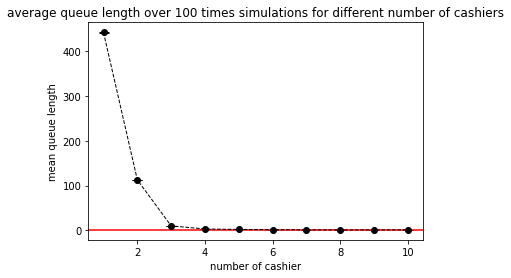

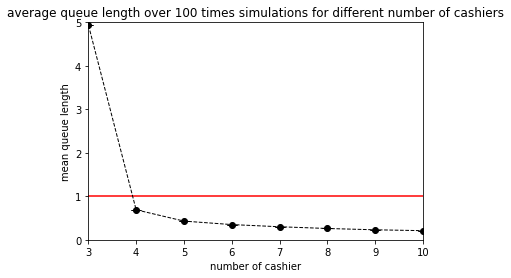

224.560000
55.980000
4.950000
0.690000
0.430000
0.350000
0.300000
0.260000
0.230000
0.210000
[2.2456e+02 5.5980e+01 4.9500e+00 6.9000e-01 4.3000e-01 3.5000e-01
 3.0000e-01 2.6000e-01 2.3000e-01 2.1000e-01]


In [47]:
plt.errorbar(
    range(1, 11), max_queue_length_mean, max_queue_length_std_err,
    color='black', marker='o', capsize=5, linestyle='--', linewidth=1)
plt.axhline(y = 1, color = 'r', linestyle = '-', label = 'queue length = 5')
plt.xlabel('number of cashier')
plt.ylabel('mean queue length')
plt.title('average queue length over 100 times simulations for different number of cashiers')
plt.show()

plt.errorbar(
    range(1, 11), avg_queue_length_mean, avg_queue_length_std_err,
    color='black', marker='o', capsize=5, linestyle='--', linewidth=1)
plt.axhline(y = 1, color = 'r', linestyle = '-', label = 'queue length = 5')
plt.xlabel('number of cashier')
plt.ylabel('mean queue length')
plt.title('average queue length over 100 times simulations for different number of cashiers')
plt.axis([3, 10, 0,5])
plt.show()

for index in range(len(avg_queue_length_mean)):
    item = avg_queue_length_mean[index]
    print("{:f}".format(item))

print(avg_queue_length_mean)


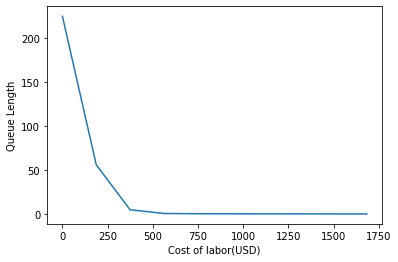

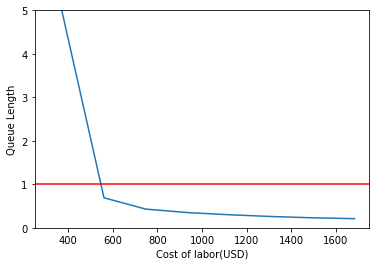

In [48]:
server_cost = list(range(0, 1850, 187))
plt.plot(server_cost, avg_queue_length_mean)
plt.ylabel('Queue Length')
plt.xlabel('Cost of labor(USD)')
plt.show()

server_cost = list(range(0, 1850, 187))
plt.plot(server_cost, avg_queue_length_mean)
plt.ylabel('Queue Length')
plt.xlabel('Cost of labor(USD)')
plt.axhline(y = 1, color = 'r', linestyle = '-', label = 'queue length = 1')
plt.axis([250, 1750, 0,5])
plt.show()